### SAM for Medical Imaging

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""

  

"""
))

In [ ]:

!git clone https://github.com/amine0110/SAM-Medical-Imaging
%cd SAM-Medical-Imaging

fatal: destination path 'SAM-Medical-Imaging' already exists and is not an empty directory.
/content/SAM-Medical-Imaging


In [ ]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib    
!pip install pydicom  
!wget -P model https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-06-11 12:50:42--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.10, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘model/sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   233MB/s    in 10s     

2023-06-11 12:50:53 (233 MB/s) - ‘model/sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import cv2
import pydicom
from google.colab.patches import cv2_imshow

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255/255, 200/255, 0/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:

image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
def prepare_dicoms(dcm_file, show=False):
    dicom_file_data = pydicom.dcmread(dcm_file).pixel_array

    HOUNSFIELD_MAX = np.max(dicom_file_data)
    HOUNSFIELD_MIN = np.min(dicom_file_data)

    HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

    dicom_file_data[dicom_file_data < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    dicom_file_data[dicom_file_data > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    normalized_image = (dicom_file_data - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE
    uint8_image = np.uint8(normalized_image*255)

    opencv_image = cv2.cvtColor(uint8_image, cv2.COLOR_GRAY2BGR)

    if show:
        cv2_imshow(opencv_image)

    return opencv_image

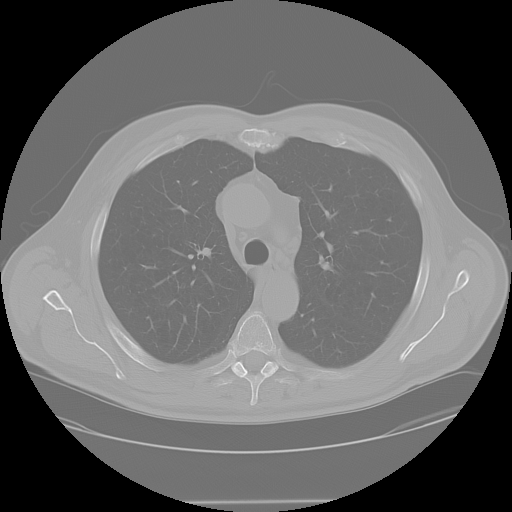

In [ ]:
img = prepare_dicoms('images/slice.dcm', show=True)

In [ ]:

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(img)
input_box = np.array([100, 100, 400, 400])

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

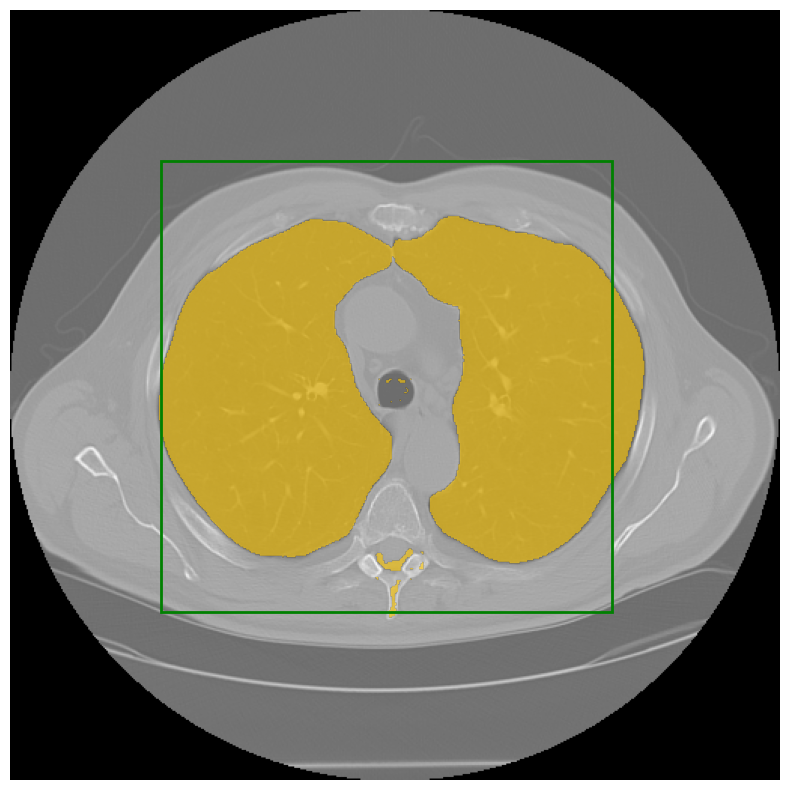

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()